**NOTEBOOK TO TEST VARIABLES IN THE 3D SPACE**

In [1]:
import numpy as np 
from numba import njit
import matplotlib.pyplot as plt 

In [2]:
#Variables to test
#These variables should later on have permanent values, unliked temp and RH which may change values

attach_prob_divisor = 500 #This determines how the attach prob should be divided. Attach prob is proportional to Max M-value given conditions
#Max M-value corresponds to a certain coverage percentage. This should be divided by something to get attach probability. Minimum 100. 

decay_prob_multiplier  = 0.01 #decay_prob is inversely proportional to attach_prob, but must be multiplied by a number smaller than 1, lest all particles just decay. 
timesteps_per_day = 1 #We need to be able to talk about how many days have passed, to be able to compare it to experimental data. 
particle_boundary = 0.2 #After simulating many runs and averaging, some places will have values between 0 and 1. Some of these should be counted when considering mold surface coverage
# The particle boundary determines when these should be counted or discounted

In [3]:

# OPTIMILIZATIONS: - dits to seed
#                   

# Constants
GRID_SIZE = 100
RADIUS = (GRID_SIZE // 2 ) + 5 # Radius of the circle
center_index = GRID_SIZE // 2
DAYS = 128 
TIMESTEPS = DAYS * timesteps_per_day
NUM_SIMS = 2
Temp = 30
RH = 97

# Initialize grid (plus 1 to account for 0-index)
grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1, GRID_SIZE + 1))
grid[center_index, center_index, center_index] = 1  # Set seed point as part of cluster

neighbor_offsets = np.array([
    [1, 0, 0], [-1, 0, 0],  # +x, -x
    [0, 1, 0], [0, -1, 0],  # +y, -y
    [0, 0, 1], [0, 0, -1]   # +z, -z
])


In [4]:

@njit
def attaching_prob(Temp, RH): 
    RH_crit = (-0.00267 * (Temp**3)) + (0.16*(Temp**2)) - (3.13*Temp) + 100
    if(RH < RH_crit):
        return 0
    M_max = 1+7*((RH_crit-RH)/(RH_crit-100))-2*((RH_crit - RH)/(RH_crit-100))**2 #The maximum M-value for the given temperature and relative humidity 
    #The above two formulas are from the paper "A mathematical model of mould growth on wooden material" by Hukka and Vitten 1999
    if(M_max < 0): 
        return 0

    area_covered = 133.6561 + (0.9444885 - 133.6561)/(1 + (M_max/4.951036)**5.67479)
    #The formula for translating M-value to surface coverage represented by that coverage, is retrieved by regression over the definition of M-value.
    #We use this as a stand-in for attachment probability. 
    #The regression is over the points (0,0), (1,1), (3,10), (4,30), (5,70), (6,100)
    #These are the points where the M-value is 0, 1, 3, 4, 5, 6, respectively as given by the table in "Development of an improved model for mould growth: Modelling"  
    #by Viitanen et al. 2008
    if area_covered > 100:
        return 1
    return area_covered/attach_prob_divisor

In [5]:
def coverage_to_m_value(cov): 
    return 14.87349 + (-0.03030586 - 14.87349)/(1 + (cov/271.0396)**0.4418942)

ATTACH_PROB = attaching_prob(Temp, RH)
DECAY_PROB = (1 - ATTACH_PROB) * decay_prob_multiplier


In [6]:
@njit
def decay_grid(grid):
    decay_amount = 0
    sum_grid = int(np.sum(grid))
    for _ in range(sum_grid):
        if np.random.uniform() < DECAY_PROB:
            decay_amount += 1
    if decay_amount == 0:
        return
    # find middle point
    sum_grid = int(np.sum(grid))
    coords = np.zeros((sum_grid, 3))
    idx = 0
    x_avg = 0
    y_avg = 0
    z_avg = 0
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            for z in range(grid.shape[2]):
                if grid[x, y, z] == 1:
                    coords[idx] = np.array((x, y, z), dtype=np.int32)
                    x_avg += x
                    y_avg += y
                    z_avg += z
                    idx += 1

    x_avg /= idx
    y_avg /= idx
    z_avg /= idx
    middle = (x_avg, y_avg, z_avg)
    
    # keep removing furthest point from middle point
    distances = np.zeros(coords.shape[0])
    for i in range(coords.shape[0]):
        distances[i] = np.sqrt((coords[i][0] - middle[0]) ** 2 + (coords[i][1] - middle[1]) ** 2 + (coords[i][2] - middle[2]) ** 2)
    for _ in range(decay_amount):
        idx = np.argmax(distances)
        furthest = coords[idx]
        grid[int(furthest[0]), int(furthest[1]), int(furthest[2])] = 0
        distances[idx] = -1

In [7]:
@njit
def in_bounds_mask(particles):
    return (
        (particles[:, 0] >= 0) & (particles[:, 0] < GRID_SIZE) &
        (particles[:, 1] >= 0) & (particles[:, 1] < GRID_SIZE) &
        (particles[:, 2] >= 0) & (particles[:, 2] < GRID_SIZE)
    )

In [8]:
@njit
def remove_indices(arr, indices_to_remove):
    # Create a mask to keep all elements by default
    mask = np.ones(len(arr), dtype=np.bool_)

    # Mark indices to remove as False
    for idx in indices_to_remove:
        mask[idx] = False

    # Filter the array using the mask
    return arr[mask]

In [9]:
@njit
def in_bounds(particles, radius):
    # if dist_to_seed >= radius + 5:
    return particles[
        (particles[:, 0] >= center_index - radius) & (particles[:, 0] < center_index + radius) &
        (particles[:, 1] >= center_index - radius) & (particles[:, 1] < center_index + radius) &
        (particles[:, 2] >= center_index - radius) & (particles[:, 2] < center_index + radius)
    ]

In [10]:
@njit
def move(particles):
    return particles + np.random.randint(-1, 2, (len(particles), 3))

In [11]:
@njit
def check_neighbor(particles, grid, batch_size):
    # numpy broadcasting
    neighbors = particles[:, None, :] + neighbor_offsets[None, :, :]
    neighbors = neighbors.reshape(-1, 3)

    # Get the valid mask for in-bounds neighbors
    mask = in_bounds_mask(neighbors)
    valid_neighbors = neighbors[mask]

    # Now match the original indices
    original_indices = np.nonzero(mask)[0]

    # Check if valid neighbors touch the grid
    hits_indices = []

    for idx, neighbor in enumerate(valid_neighbors):
        x, y, z = int(neighbor[0]), int(neighbor[1]), int(neighbor[2])
        if grid[x, y, z] == 1:
            if np.random.uniform() < ATTACH_PROB:
                hits_indices.append(original_indices[idx]) # Track original particle indices

    # Filter original particles by hits
    hits = [particles[i // 6] for i in hits_indices]
    p_indices = [i // 6 for i in hits_indices]

    # hits = []
    # mask = np.ones(len(particles), dtype=np.bool_)

    # for i in prange(len(hits_indices)):
    #     ind = hits_indices[i]
    #     p_index = ind // 6
    #     hits.append(particles[p_index])
    #     mask[p_index] = False


    # is_occupied = np.zeros(len(neighbors))

    # for i in range(len(neighbors)):
    #     x, y, z = int(neighbors[i, 0]), int(neighbors[i, 1]), int(neighbors[i, 2])
    #     if grid[x, y, z] == 1:
    #         is_occupied[i] = 1

    # hits_indices = np.where(is_occupied == 1)[0]

    # hits = [particles[i // 6] for i in hits_indices]

    return hits, p_indices

In [12]:
@njit
# This decorator tells Numba to compile this function using the JIT (just-in-time) compiler
def particle_loop(grid, batch_size=1000):

    reached_edge = False
    current_radius = 5 #spawns particles closer to where the seed is, to speed up the program. 
    particle_count = 0

    for i in range(TIMESTEPS):  #keeps going until a particle touches the radius of the circle while being attached to the body
    # Create the particle starting from a random point on the circle
    
    # http://datagenetics.com/blog/january32020/index.html

        if i % 10 == 0:
            decay_grid(grid)

        theta = np.random.uniform(0, 2 * np.pi, batch_size)
        phi = np.random.uniform(0, np.pi, batch_size)

        # Initialize an empty array to hold the particle coordinates
        particle = np.zeros((batch_size, 3))

        if reached_edge == False:
        # Populate the particle array manually
            particle[:, 0] = (GRID_SIZE / 2 + current_radius * np.sin(phi) * np.cos(theta))
            particle[:, 1] = (GRID_SIZE / 2 + current_radius * np.sin(phi) * np.sin(theta))
            particle[:, 2] = (GRID_SIZE / 2 + current_radius * np.cos(phi))
        else:
            particle[:, 0] = (np.random.randint(0, GRID_SIZE, batch_size))
            particle[:, 1] = (np.random.randint(0, GRID_SIZE, batch_size))
            particle[:, 2] = (np.random.randint(0, GRID_SIZE, batch_size))
            

        particle = np.floor(particle)
        particle_count += batch_size

        particle = in_bounds(particle, current_radius)

        # print(particle_count)

        while len(particle) > 0:

            # LOOP THROUGH PARTICLE AND CALCULATE DIST TO SEED, GEEFT DISTANCE MEE MET PARTICLE, ZO HOEF JE MAAR 1 KEER TE BEREKENEN
            particle = move(particle)

            particle = in_bounds(particle, current_radius)

            # check neighbors and update grid
            hits, p_indices = check_neighbor(particle, grid, batch_size)

            # Update grid
            for hit in hits:
                x, y, z = int(hit[0]), int(hit[1]), int(hit[2])
                grid[x, y, z] = 1
                dist_to_seed = np.linalg.norm(hit - center_index)
                if dist_to_seed >= current_radius - 1 and reached_edge == False:
                    current_radius += 5 
                    if current_radius > RADIUS:
                        reached_edge = True
         
            # Remove particles that already attached themselves to the cluster
            particle = remove_indices(particle, p_indices)

    return


In [13]:
def monte_carlo():
    aggr_grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1, GRID_SIZE + 1))
    for _ in range(NUM_SIMS):
        # Initialize grid (plus 1 to account for 0-index)
        grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1, GRID_SIZE + 1))
        grid[center_index, center_index, center_index] = 1
        particle_loop(grid)

        aggr_grid += grid

    aggr_grid = aggr_grid/NUM_SIMS
    mold_grid = aggr_grid.copy()
    mold_grid[ mold_grid > particle_boundary ] = 1
    
    mold_cov_3d = np.mean(mold_grid) * 100
    mold_cov_surface = np.mean(mold_grid[:,center_index,:]) * 100

    return aggr_grid, mold_cov_3d, mold_cov_surface

attach_prob: 0.1763731082643741
decay_prob:  0.008236268917356258
Average mold coverage:  2.1459748170680215 %
M-value:  1.5411633707711978
Average mold coverage surface:  10.351926281737086 %
M-value surface:  2.817931842910726
Temperature:  30
Relative Humidity:  97


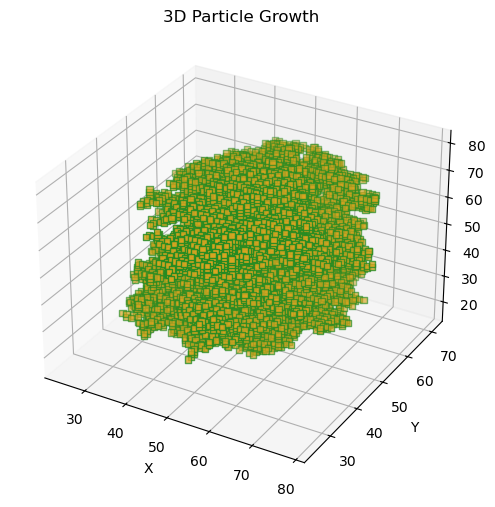

In [14]:


final_grid, mold_cov_3d, mold_cov_surface = monte_carlo()
print("attach_prob:" , ATTACH_PROB)
print("decay_prob: ", DECAY_PROB)
print("Average mold coverage: ", mold_cov_3d , "%")
print("M-value: ", coverage_to_m_value(mold_cov_3d))
print("Average mold coverage surface: ", mold_cov_surface , "%")
print("M-value surface: ", coverage_to_m_value(mold_cov_surface))
print("Temperature: "   , Temp)
print("Relative Humidity: " , RH)
# Plot the result
# plt.imshow(final_grid, cmap='Greens', interpolation='nearest')
# plt.show()

x, y, z = np.where(final_grid >= 1 / NUM_SIMS)

# Plot the 3D grid
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# alphas = final_grid[x, y, z]

# alpha waarde die value in final grid
scatter = ax.scatter(x, y, z, c='goldenrod', s=GRID_SIZE//5, marker='s', edgecolor='forestgreen')

# Set plot labels
ax.set_title("3D Particle Growth")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
